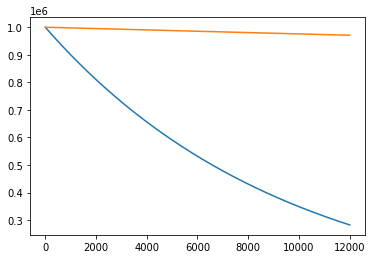

In [1]:
import math
import matplotlib.pyplot as mpl

# Times in seconds
def ActivityAtTime( StartingActivity, TimeElapsed, HalfLife ):
    return StartingActivity * ( 2.0 ** ( -TimeElapsed / HalfLife ) )

def F18ActivityAtTime( StartingActivity, TimeElapsed ):
    return ActivityAtTime( StartingActivity, TimeElapsed, 109.77*60.0 )

def Zr89ActivityAtTime( StartingActivity, TimeElapsed ):
    return ActivityAtTime( StartingActivity, TimeElapsed, 78.41*60.0*60.0 )

def ActivityPlot( StartingActivity, EndTime, ActivityMethod ):
    activityValues = []
    timeValues = []
    time = 0.0
    while time < EndTime:
        activityValues.append( ActivityMethod( StartingActivity, time ) )
        timeValues.append( time )
        time += 1.0
        
    mpl.plot( timeValues, activityValues )
    
ActivityPlot( 1E6, 200.0*60.0, F18ActivityAtTime )
ActivityPlot( 1E6, 200.0*60.0, Zr89ActivityAtTime )
mpl.show()

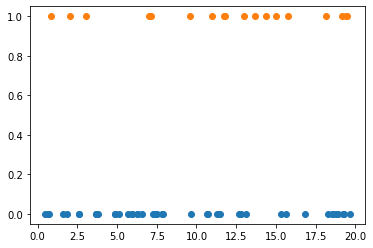

In [2]:
import random

# Simulate poisson-distributed random decay times
# Based on example https://timeseriesreasoning.com/contents/poisson-process/
def DeltaT( DecayRate ):
    randUniform = random.random()
    return -math.log( 1.0 - randUniform ) / DecayRate

def ActivityTimeline( DecayRate, EndTime ):
    decayTimes = []
    time = 0.0
    while time < EndTime:
        time += DeltaT( DecayRate )
        if time < EndTime:
            decayTimes.append( time )
            
    return decayTimes
            
def TimelinesPlot( Timelines ):
    for i, decayTimes in enumerate( Timelines ):
        dummyY = []
        for time in decayTimes:
            dummyY.append( i )
            
        mpl.scatter( decayTimes, dummyY )

TimelinesPlot( [ ActivityTimeline( 2, 20 ), ActivityTimeline( 1, 20 ) ] )
mpl.show()

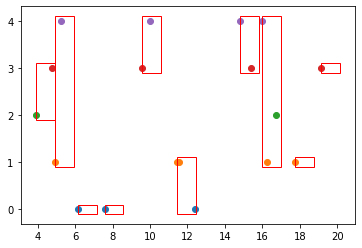

[[2, 3], [1, 4], [0], [0], [3, 4], [0, 1, 1], [3, 4], [1, 2, 4], [1], [3]]


In [3]:
import sys
from matplotlib.patches import Rectangle

def FindCoincidences( Timelines, TimeWindow ):
    coincidences = []
    coincidenceTimes = []
    
    # Find the first event in each timeline
    nextTimes = []
    nextIndices = []
    for decayTimes in Timelines:
        if len( decayTimes ) == 0:
            nextTimes.append( sys.float_info.max )
        else:
            nextTimes.append( decayTimes[0] )
        nextIndices.append( 0 )
    
    unfinishedTimeline = True
    while unfinishedTimeline:

        # Start the window at the first unprocessed event
        time = min( nextTimes )
        #print( nextTimes, " min = ", time )
    
        # Find all events in the window
        coincidence = []
        for timelineIndex, nextTime in enumerate( nextTimes ):
            #print( "testing", timelineIndex, nextTime, " against ", time )
            if nextTime >= time and nextTime <= time + TimeWindow \
                and nextTime < sys.float_info.max - TimeWindow: # to catch the dummy values
                #print( "coincidence!" )
                coincidence.append( timelineIndex )
                
        # Catch a no-coincidence (including self) because we've ended up all infinities
        if len( coincidence ) == 0:
            break
    
        # Update to the next time for anything in the coincidence window
        unfinishedTimeline = False
        finalCoincidence = []
        for timelineIndex in coincidence:
            
            # Find the first time that's outside the current window
            nextIndex = nextIndices[ timelineIndex ]
            nextTime = Timelines[ timelineIndex ][ nextIndex ]
            while nextTime <= time + TimeWindow:
                
                # Add entries if there is coincidence within the window for a single timeline
                finalCoincidence.append( timelineIndex )
                nextIndex += 1
            
                # Test for reaching the end of the timeline
                if nextIndex >= len( Timelines[ timelineIndex ] ):
                    nextTimes[ timelineIndex ] = sys.float_info.max
                    nextIndices[ timelineIndex ] = -1
                    break
                else:
                    nextTime = Timelines[ timelineIndex ][ nextIndex ]
                    nextTimes[ timelineIndex ] = nextTime
                    nextIndices[ timelineIndex ] = nextIndex
                    unfinishedTimeline = True
        
        # Need to search for dummy indices since we don't update everything each round
        for nextIndex in nextIndices:
            if nextIndex > -1:
                unfinishedTimeline = True
                break
                
        coincidences.append( finalCoincidence )
        coincidenceTimes.append( time )
    
    return coincidences, coincidenceTimes

def CoincidenceBoxes( Coincidences, CoincidenceTimes, TimeWindow ):
    
    for i, coincidence in enumerate( Coincidences ):
        time = CoincidenceTimes[ i ]
        y = min( coincidence )
        height = max( coincidence ) - y
        y -= 0.1
        height += 0.2
        mpl.gca().add_patch( Rectangle( (time, y), TimeWindow, height, \
                                        linewidth=1,edgecolor='r',facecolor='none') )
        
exampleTimelines = [ ActivityTimeline( 0.2, 20 ), ActivityTimeline( 0.2, 20 ), ActivityTimeline( 0.2, 20 ), ActivityTimeline( 0.2, 20 ), ActivityTimeline( 0.2, 20 ) ]
coincidences, coincidenceTimes = FindCoincidences( exampleTimelines, 1 )
TimelinesPlot( exampleTimelines )
CoincidenceBoxes( coincidences, coincidenceTimes, 1 )
mpl.show()

print( coincidences )

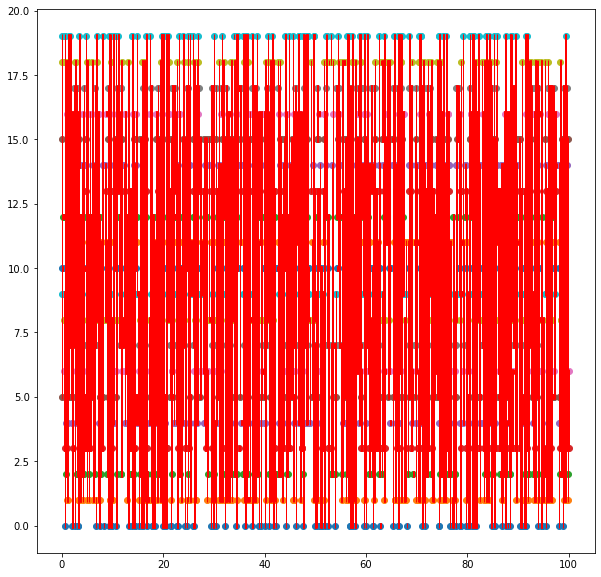

[[5, 9, 15, 18, 19], [10], [12], [6, 8, 9], [3, 9], [0, 10, 12, 12, 18, 19, 19], [2, 4, 18, 18], [6, 18], [3, 7, 9, 12], [1, 1, 12, 16, 18], [4, 7, 18], [5, 10, 19], [7, 14, 19], [5, 9, 10, 15], [4, 11], [0, 16], [3], [7, 10, 12, 17], [0, 12], [5, 7, 10, 18], [4, 6, 7, 12, 14, 15, 18], [2, 2, 14, 17, 17], [8, 9, 10], [0, 0, 1, 4, 14, 16], [14, 15, 19], [3, 11], [1, 3, 6, 10, 12], [2, 6, 7], [6, 11, 12, 14], [1, 16], [2, 7, 12, 17], [10], [3, 5], [4, 13, 14, 14, 15, 19], [1, 6, 18], [7, 8, 18], [3, 8, 9, 12], [1, 2, 6], [12], [7, 10, 12, 16], [3, 8, 12], [11], [5, 18], [9, 11], [1, 9, 9, 10, 14], [2, 9, 17], [7, 16], [0, 1], [8, 18, 19], [7], [1, 4, 9, 16, 16], [0, 1, 5, 8], [5, 10, 12], [2, 10, 10, 11], [8], [3, 11, 14, 19], [5, 8, 14], [0], [8, 14], [13], [16], [2, 11], [5, 15, 17], [0, 2, 11, 14], [5, 14, 19], [0, 1, 6, 13, 14], [1, 16], [0, 9, 18, 19], [0, 8], [3], [1, 11], [6, 13, 19], [4, 8, 13], [10, 15], [5, 6, 12, 19, 19], [0, 15, 16], [2, 8, 17], [13, 16, 19], [10], [7, 10, 12

In [8]:
# Large test for performance
largeTimelineSet = []
for i in range( 20 ):
    largeTimelineSet.append( ActivityTimeline( 1, 100 ) )
coincidences, coincidenceTimes = FindCoincidences( largeTimelineSet, 0.1 )
TimelinesPlot( largeTimelineSet )
CoincidenceBoxes( coincidences, coincidenceTimes, 0.1 )

mpl.gcf().set_size_inches(10, 10)
mpl.show()

print( coincidences )

[0.6023987296334543, 0.6366347902478061, 1.3833996994239166, 0.9385151953506053, 1.3179019928206417, 0.9322263121681419, 0.04998350858371001, 0.19040901551899203, 0.16155489959550834, 0.9281717928499712, 0.05190331702066388, 1.3717631008567854, 0.6515671240592268, 0.14983212058355982, 1.0683063248839122, 0.4016557916496483, 0.2990797745949165, 1.5639855077028901, 0.7914342783038019, 0.18506588048035616]  min =  0.04998350858371001
[6, 10, 13]
[0.6023987296334543, 0.6366347902478061, 1.3833996994239166, 0.9385151953506053, 1.3179019928206417, 0.9322263121681419, 1.2675161598868274, 0.19040901551899203, 0.16155489959550834, 0.9281717928499712, 0.20913248918586885, 1.3717631008567854, 0.6515671240592268, 0.386543357759663, 1.0683063248839122, 0.4016557916496483, 0.2990797745949165, 1.5639855077028901, 0.7914342783038019, 0.18506588048035616]  min =  0.16155489959550834
[7, 8, 10, 19]
[0.6023987296334543, 0.6366347902478061, 1.3833996994239166, 0.9385151953506053, 1.3179019928206417, 0.932

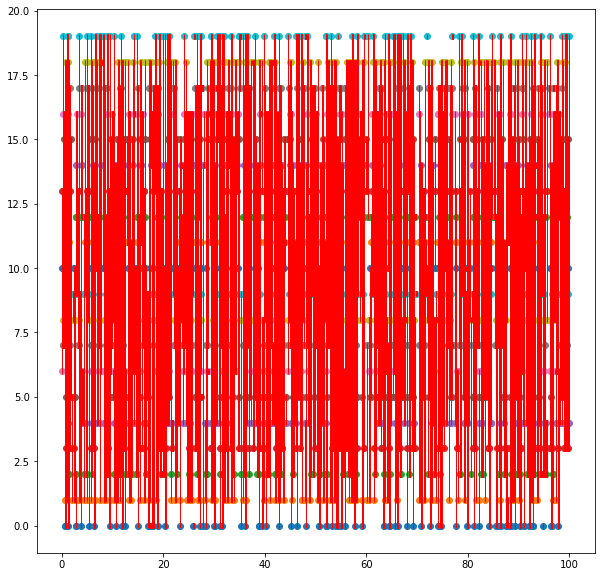

[[6, 10, 13], [7, 8, 10, 19], [7, 13, 16], [8, 15], [0, 1, 12], [0, 0, 7, 18], [1, 3, 5, 9, 18], [3, 8, 14], [15, 19, 19], [0, 4, 6, 16, 18], [2, 11], [3, 17], [7, 13, 15], [5, 15], [1, 5], [8, 9], [1, 3, 9, 10, 10], [5, 8], [0, 0, 1, 2], [9, 12, 12, 14, 16], [7, 9, 13], [1, 7, 8, 17, 19], [1, 9], [0, 16], [12, 14, 17], [4, 6], [1, 2, 9, 12], [9, 11, 18], [2, 4, 13], [1, 18, 19], [17], [8, 17], [0, 12], [1, 3, 7, 9, 10, 13, 15, 19], [6, 7, 12], [2, 4, 18], [3, 7, 10, 11, 14, 17], [3, 8], [0, 3, 4, 6, 14], [1, 15, 18], [10, 11, 18, 19], [4, 4, 10, 17, 18], [4, 4, 12], [7, 9, 18, 19], [1, 4, 12], [6, 14, 19], [18], [10, 19], [4, 6, 19], [1, 8, 17], [4, 17], [1, 8, 12], [7, 9, 11], [4, 16, 17], [2, 9, 19], [3], [5, 7], [0, 5, 13], [1, 5, 8, 19], [6, 12], [7, 13, 15], [7, 10], [8, 16], [5, 6], [2, 4, 5, 10, 19], [1, 11], [6, 14, 14], [0, 9, 10], [1, 4], [1, 15], [2, 4, 15, 18], [2, 5, 6], [1, 17], [2, 8, 11, 19], [15, 17], [14], [0, 5, 7, 11, 18], [6, 6, 12], [3, 15], [0, 18], [2, 6], [13]

In [9]:
# Avoid pre-generating timelines since it blows up the RAM
def GenerateCoincidences( Channels, DecayRate, EndTime, TimeWindow, TimelinesOut = None ):
    coincidences = []
    coincidenceTimes = []
    
    # Set the first event in each timeline
    nextTimes = []
    for decayTimes in range( Channels ):
        nextTimes.append( DeltaT( DecayRate ) )
        if TimelinesOut is not None:
            TimelinesOut.append( [] )
    
    unfinishedTimeline = True
    while unfinishedTimeline:

        # Check if we have anything to process
        unfinishedTimeline = False
        for nextTime in nextTimes:
            if nextTime <= EndTime:
                unfinishedTimeline = True
                break
        
        # Start the window at the earliest event
        time = min( nextTimes )
        print( nextTimes, " min = ", time )
    
        # Find all events in the window
        coincidence = []
        for channelIndex, nextTime in enumerate( nextTimes ):
            
            while nextTime <= time + TimeWindow and nextTime <= EndTime:
                
                # Store the time point
                coincidence.append( channelIndex )
                if TimelinesOut is not None:
                    TimelinesOut[ channelIndex ].append( nextTime )
                    
                # Update to next time point
                nextTime += DeltaT( DecayRate )
                
            # Store the first event outside the window, for the next coincidence
            nextTimes[ channelIndex ] = nextTime
        
        # The last entry is empty, because all times now past end
        if len( coincidence ) > 0:
            print( coincidence )    
            coincidences.append( coincidence )
            coincidenceTimes.append( time )
    
    return coincidences, coincidenceTimes

quickTimelines = []
coincidences, coincidenceTimes = GenerateCoincidences( 20, 1, 100, 0.1, quickTimelines )
TimelinesPlot( quickTimelines )
CoincidenceBoxes( coincidences, coincidenceTimes, 0.1 )

mpl.gcf().set_size_inches(10, 10)
mpl.show()

print( coincidences )